# Signal Filter Design for the VARIO

### Python imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
# get minimize from scipy
from scipy.optimize import minimize

import JETI_Log_Parser as JLP

### Filter variants

##### Exponential filter

In [2]:
def exponential_filter(value: float, smoothing_factor: float, last_value: float) -> float:
    """Applies an exponential filter using @native with type hints."""
    return value + smoothing_factor * (last_value - value)

##### Double exponential filter with rate of change calculation
A double exponential filter. The raw signal is smoothed with two different time constants. Then the rate of change of these two signals is calculated and smoothed with an exponential filter again.

In [3]:
def double_exponential_filter(signal,
                              old_signal_1,
                              old_signal_2,
                              old_rate,
                              tau_1, tau_2, dyn_alpha_divisor,
                              delta_t):

        alfa_1 = delta_t / (tau_1 + delta_t)
        alfa_2 = delta_t / (tau_2 + delta_t)

        # double exponential smoothing
        smoothed_signal_1 = old_signal_1 - alfa_1 * (old_signal_1 - signal)
        smoothed_signal_2 = old_signal_2 - alfa_2 * (old_signal_2 - signal)

        # rate of change; factor is to convert from seconds to milliseconds
        factor = 1000.0 / (tau_2 - tau_1 + 1.e-9)
        rate = (smoothed_signal_1 - smoothed_signal_2) * factor

        # exponential smoothing of the rate of change with dynamic alpha
        dyn_alpha = abs((old_rate - rate) / dyn_alpha_divisor)
        dyn_alpha = min(dyn_alpha, 1.0)
        smoothed_rate = old_rate - dyn_alpha * (old_rate - rate)

        return smoothed_signal_1, smoothed_signal_2, smoothed_rate


### Altitude calculation

In [4]:
# calculate the altutude based on pressure (Pa) and standard atmosphere
def altitude_from_pressure(pressure, sea_level_pressure=101325):
    return 44330.8 * (1.0 - (pressure / sea_level_pressure)**(1/5.255))

### Parse exmple LOG file
Contains raw pressure signal from an MS5611 sensor

In [5]:
# read example log data from a file
filename = 'JETI_sample.log'

with open(filename, "r", encoding='utf-8', errors='replace') as file:
    telemetry_log_data = file.read()

# Create a parser instance and parse the log data
parser = JLP.JetiTelemetryParser(telemetry_log_data)
parser.parse()

devices = parser.get_devices()

# print devices and channels
for device_name, device_data in devices.items():
    print(f"Device: {device_name}")
    for channel_id, channel_data in device_data["channels"].items():
        print(f"  Channel {channel_id}: {channel_data['name']} ({channel_data['unit']})")


Device: Tx
Device: REX7A
  Channel 1: U Rx (V)
  Channel 2: A1 ()
  Channel 3: A2 ()
  Channel 4: Q (%)
  Channel 14: Temperatur (°C)
  Channel 15: Roll (°)
  Channel 16: Nick (°)
  Channel 17: Heck (°)
  Channel 18: G-Kraft (G)
  Channel 19: Status ()
Device: MHB
  Channel 2: Hoehe (m)
  Channel 3: Max. altitude (m)
  Channel 4: Vario (m/s)
  Channel 5: Max. climb (m/s)
  Channel 6: Druck (mbar)
  Channel 7: Temperature (C)
  Channel 15: Raw Pressure (Pa)


### Extract raw pressure signal

In [6]:
# Specify the device and channel you want to plot
target_device = "MHB"
target_channel_id = 15

# Retrieve the channel's data
if target_device in devices and target_channel_id in devices[target_device]["data"]:
    data = devices[target_device]["data"][target_channel_id]

timestamps = data[:, 0]
signal = data[:, 1]

### FFT for frequency content

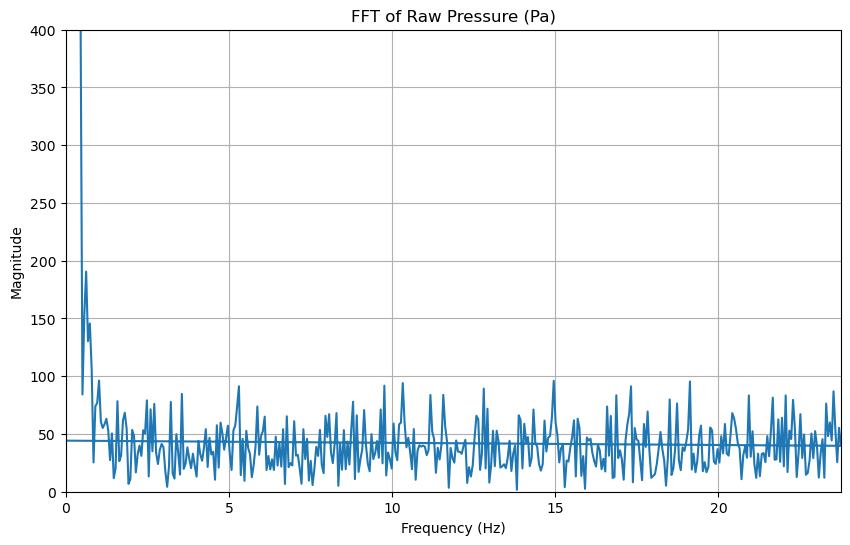

In [7]:
# make an fft on the signal to see the frequency content
fft_signal = np.fft.fft(signal)
timestamps_in_seconds = timestamps / 1000.0

# calculate the frequencies
frequencies = np.fft.fftfreq(len(signal), d=timestamps_in_seconds[1] - timestamps_in_seconds[0])
# plot the FFT
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_signal))
plt.title(f"FFT of {devices[target_device]['channels'][target_channel_id]['name']} ({devices[target_device]['channels'][target_channel_id]['unit']})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, np.max(frequencies))
plt.ylim(0, 400)
plt.grid()
plt.show()

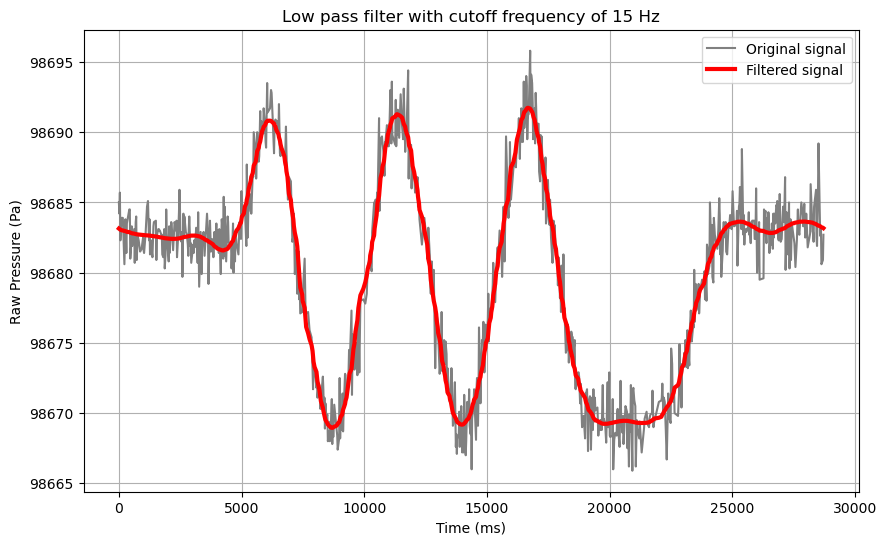

In [36]:
# make a low pass filter and allow to set the cutoff frequency
def low_pass_filter(signal, cutoff_frequency, sampling_frequency):
    # calculate the number of samples
    n_samples = len(signal)
    # calculate the frequencies
    frequencies = np.fft.fftfreq(n_samples, d=1.0 / sampling_frequency)
    # create a filter
    filter = np.ones(n_samples)
    filter[np.abs(frequencies) > cutoff_frequency] = 0
    # apply the filter
    filtered_signal = np.fft.ifft(np.fft.fft(signal) * filter)
    return np.real(filtered_signal)

# apply the low pass filter
cutoff_frequency = 15
LP_filtered_signal = low_pass_filter(signal, cutoff_frequency, 1000)

# plot the filtered signal
plt.figure(figsize=(10, 6))
plt.plot(timestamps, signal, label="Original signal", color="gray")
plt.plot(timestamps, LP_filtered_signal, label="Filtered signal", color='red', lw=3)
plt.title(f"Low pass filter with cutoff frequency of {cutoff_frequency} Hz")
plt.xlabel("Time (ms)")
plt.ylabel(f"{devices[target_device]['channels'][target_channel_id]['name']} ({devices[target_device]['channels'][target_channel_id]['unit']})")
plt.legend()
plt.grid()
plt.show()

### Filter the signal
Filter the altitude which is calculated from pressure at standard atmosphere. Use predefined time constants for the double exponential filter.

Use a double exponential filter with different time bases, calculate the "average" slope and smooth this using an exponential filter with dynamic alpha.

In [22]:
# calculate the altitude from the filtered pressure
# altitude = altitude_from_pressure(filtered_signal)
altitude = altitude_from_pressure(signal)

# run the double exponential filter on the altitude
old_signal_1 = altitude[0]
old_signal_2 = altitude[0]
old_rate = 0.0
smoothed_altitude_1 = np.zeros_like(altitude)
smoothed_altitude_2 = np.zeros_like(altitude)
climb_rate = np.zeros_like(altitude)
delta_t = np.diff(timestamps, prepend=timestamps[0])

# Define time constants for the filter
tau_1 = 200
tau_2 = 1800
dyn_alpha_divisor = 0.05

for i in range(len(altitude)):
    old_signal_1, old_signal_2, old_rate = double_exponential_filter(altitude[i],
                                                                    old_signal_1,
                                                                    old_signal_2,
                                                                    old_rate,
                                                                    tau_1, tau_2, dyn_alpha_divisor,
                                                                    delta_t[i])
    smoothed_altitude_1[i] = old_signal_1
    smoothed_altitude_2[i] = old_signal_2
    climb_rate[i] = old_rate


### Plot results
Plot the raw signal (altitude), the smoothed signals (for each time constant) and the smoothed climb rate.

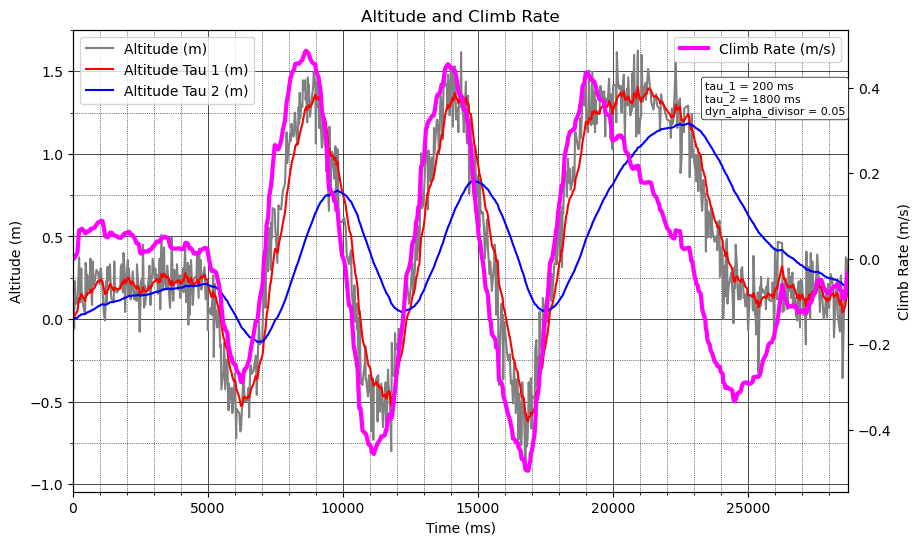

In [23]:
# Recalculate the altitude so that the first value is zero
altitude = altitude - altitude[0]
smoothed_altitude_1 = smoothed_altitude_1 - smoothed_altitude_1[0]
smoothed_altitude_2 = smoothed_altitude_2 - smoothed_altitude_2[0]

# Plot the altitude, its smoothed versions, and the climb rate at the right y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(timestamps, altitude, label="Altitude (m)", color='grey')
ax1.plot(timestamps, smoothed_altitude_1, label="Altitude Tau 1 (m)", color='r')
ax1.plot(timestamps, smoothed_altitude_2, label="Altitude Tau 2 (m)", color='b')
ax2.plot(timestamps, climb_rate, label="Climb Rate (m/s)", color='magenta', lw=3)

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Altitude (m)")
ax2.set_ylabel("Climb Rate (m/s)")

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Altitude and Climb Rate")
# Set grid with specific ticks
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Set major and minor ticks for x-axis
ax1.xaxis.set_major_locator(plt.MultipleLocator(5000))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(1000))
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.25))

# start x-axis from 0
plt.xlim(0, timestamps[-1])

# add the filter parameters to the plot in a box with white background and black outline
props = dict(boxstyle='round', facecolor='white', edgecolor='black', lw=0.5)
textstr = f"tau_1 = {tau_1} ms\ntau_2 = {tau_2} ms\ndyn_alpha_divisor = {dyn_alpha_divisor}"
plt.text(0.815, 0.89, textstr, transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)

plt.show()